In [2]:
import numpy as np
import pandas as pd
import sklearn as skit
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import rank
import re

alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [3]:
import Scraper
#Scraper.scrape('Plzeň')
# pouštěno jenom v IDE

In [4]:
results_summarized = pd.read_csv('data/summary.csv', sep=';', index_col=None)
candidates = pd.read_csv('data/candidates.csv', sep=';', index_col=None) 
party_results = pd.read_csv('data/party_votes.csv', sep=';', index_col=None)

# Volební účast v městě Plzeň

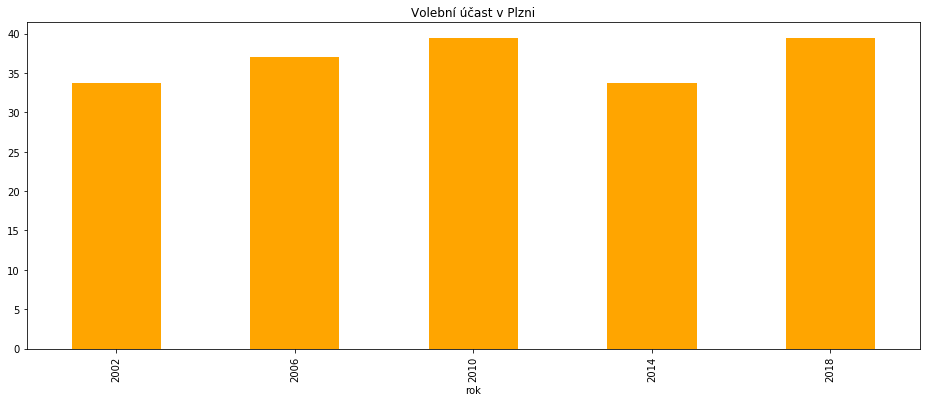

In [5]:
pt = results_summarized[['rok', 'ucast_procenta']]
pt = pt.plot(kind='bar', color='orange', x='rok', y='ucast_procenta', title="Volební účast v Plzni", legend=False, figsize=(16, 6))

Podle grafu účasti voleb do zastupitelstev obcí se občané Plzně drží v rozmezí **34 až 40 %**. Což je sice celkem stabilní číslo, ale fakt, že pravidelně volí pouze menšina obyvatelstva, zjednodušuje například cílení reklam a kampaní na tyto voliče. Takže dobře cílená kampaň by mohla jednoduše ovlivnit výsledky voleb.

### Kromě lidí, kteří vůbec nechodí volit existuje další zajímavá skupina a to lidé, kteří sice přišli volit, ale z nějakého důvodu proces nedokončili.

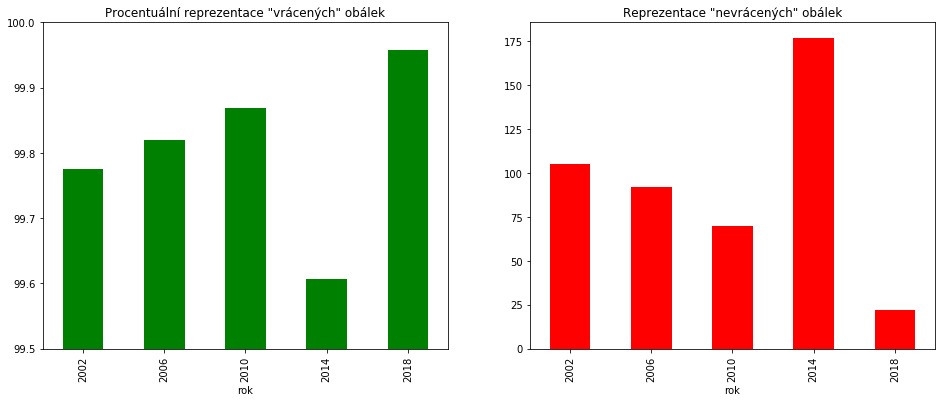

In [6]:
pt = results_summarized[['rok', 'odevzdane_obalky', 'vydane_obalky']].copy(deep=True)
pt.sort_values(by=['rok'])

pt['perc'] =  pt['odevzdane_obalky'] / (pt['vydane_obalky']/100)
pt['abs'] =   pt['vydane_obalky'] - pt['odevzdane_obalky']

fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(16, 6))
pt.plot(kind='bar',color='green', ax=ax,x='rok', y=['perc'], title='Procentuální reprezentace "vrácených" obálek', ylim=(99.5, 100), legend=False)
pt.plot(kind='bar',color='red',ax=ax2 ,x='rok', y=['abs'], title='Reprezentace "nevrácených" obálek', legend=False)
plt.show()

**Počet odevzdaných obálek** nám dává informaci o tom, kolik lidí se dostavilo k volbám, převzalo obálku s volebními lístky a úspěšně odvolilo. Její doplněk je vlasně počet voličů, kteří si vyzvedli volební lístek, ale z nějakého důvodu neodvolili. Důvody mohly být různé, například [zdražení piva Pilsner Urquell](https://www.idnes.cz/ekonomika/test-a-spotrebitel/prazdroj-zdrazuje-premiova-piva.A140829_115410_test_fih), ke kterému došlo právě v roce 2014.

### Pokud nás však zajímají samotné výsledky voleb

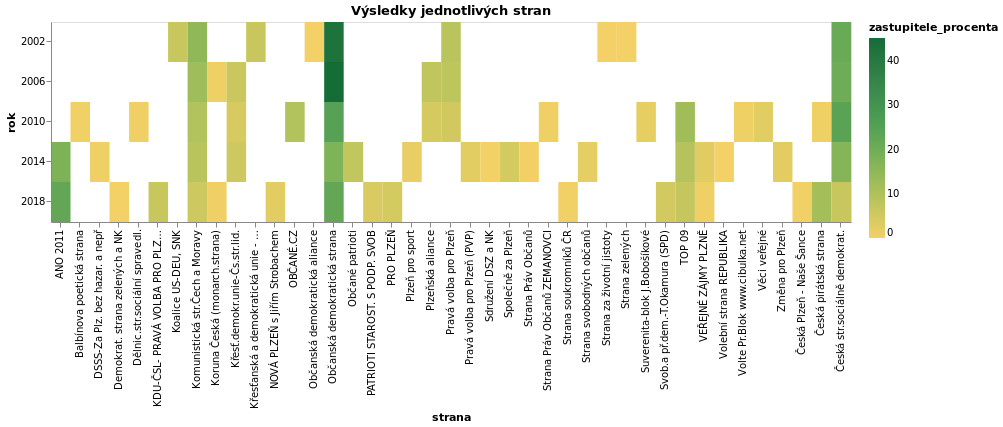

In [7]:
interval_x = alt.selection_interval(encodings=['x'], empty='none')
data = party_results[['strana', 'rok', 'zastupitele_procenta']].copy(deep=True)
alt.Chart(data.sort_values('strana'), title='Výsledky jednotlivých stran').mark_rect().encode(
    alt.X('strana', bin=False),
    alt.Y('rok:O', bin=False),
    alt.Color('zastupitele_procenta:Q', scale=alt.Scale(scheme='goldgreen')),
).properties(
    height=200,
    width=800
).display(renderer='svg')

tak z grafu výsledků je vidět, že **Občanská demokratická strana** má v Plzni dlouholetou tradici, avšak v podleních dvou volebních obdobích roste na síle hnutí **ANO 2011**. Mezi další evergreeny voleb patří **ČSSD**, **KSČM**, **TOP09** a **KDÚ-ČSL**. Kde po každých volbách aspoň jedna z těchto silněji volených stran vytvořila koalici, čímž si zařídili větší sílu při hlasování.

### Mohlo by nás například zajímat, jestli strany, které nebyly úspěšné, dále pokračovaly v kandidatůře.

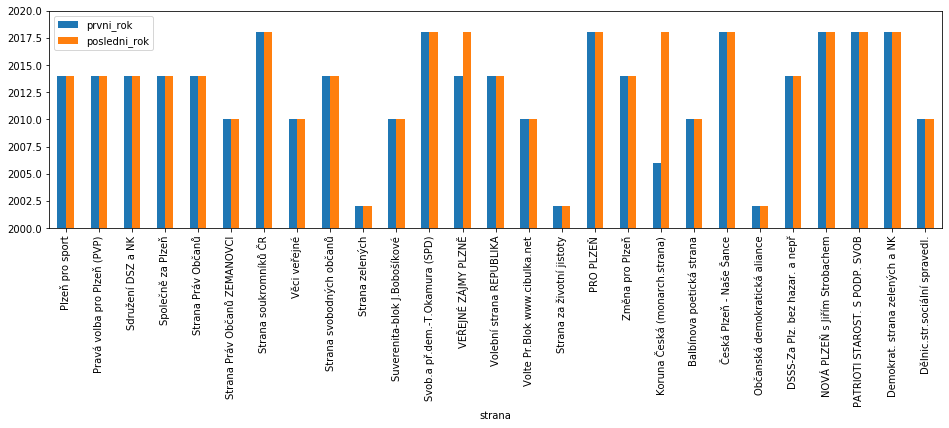

In [8]:
data = party_results[['strana', 'rok', 'hlasy', 'zastupitele']].copy(deep=True)
data = data.groupby('strana').agg({'rok':['min', 'max'], 'hlasy':['min', 'max'], 'zastupitele':'max'}).sort_values([('zastupitele', 'max')], ascending=True)
data = data[data['zastupitele']['max']<1]
data['pocet_obdobi'] = 1+(data['rok']['max']-data['rok']['min'])/4
data['pouze_jednou'] = data['hlasy']['min']==data['hlasy']['max']
data.columns = [ 'prvni_rok', 'posledni_rok', 'min_hlasy', 'max_hlasy','pocet_zastupitelu', 'pocet_obdobi', 'pouze_jednou']

tmp = data.copy(deep=True)
tmp['pouze_jednou'] = tmp['pouze_jednou'].astype(int)
a = tmp.plot(kind='bar', y=['prvni_rok', 'posledni_rok'], figsize=(16,4), layout=(1,3), ylim=(2000, 2020))

Z tohoto grafu vidíme, že většina takových stran s největší pravděpodobností vzdala snahu o to protlačit se v dalším volebním období. Mezi vyjímky však patří **Koruna Česká** a **VEŘEJNÉ ZÁJMY PLZNĚ**, které ve snaze evidentně pokračovaly. V neposlední řadě je třeba zmíňit, že 7 stran, které s kandidaturou začaly až v roce 2018 ještě mohou v příštích volbách překvapit, jelikož o nich nemáme jisté, jestli kandidování zanechaly.

In [9]:
# tituly a zeny
cand = candidates.copy(deep=True)
cand['pocet_titulu'] = cand['tituly'].apply(lambda x: 0 if not isinstance(x, str) else len(x.split(' ')))
cand['titul_rank'] = cand['tituly'].apply(rank.rank_titul)
cand['mandat'] = cand['mandat'].apply(lambda x: 1 if x else 0) 
regexp = re.compile('ová|ná|ská|ická|ká')
cand['zena'] = cand['jmeno'].apply(lambda x: 1 if regexp.search(x) is not None else 0)

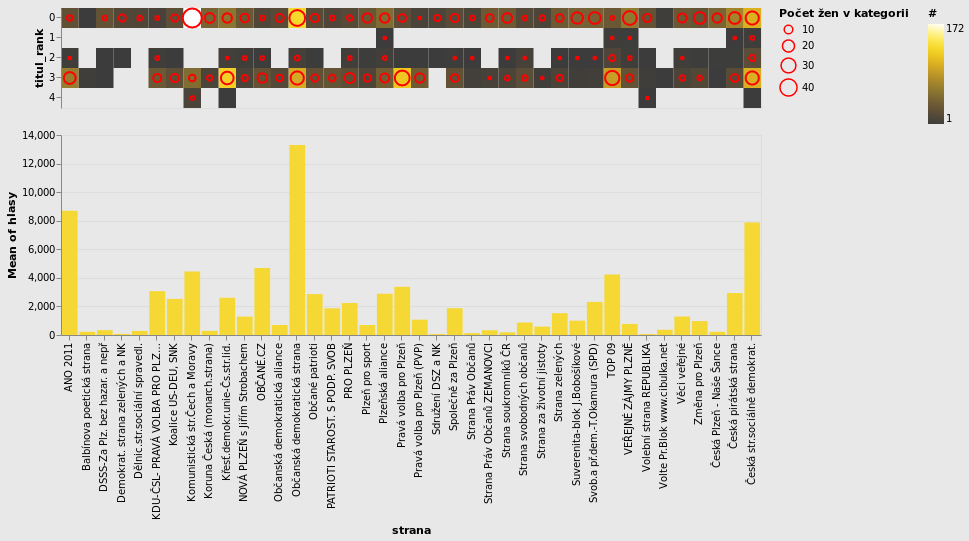

In [10]:
pts = alt.selection(type="single", encodings=['x'])
rect = alt.Chart(cand).mark_rect().encode(
    alt.X('strana:O', bin=False, axis=None),
    alt.Y('titul_rank:O', bin=False),
    alt.Color('count()',
        scale=alt.Scale(scheme='darkgold'),
        legend=alt.Legend(title='#')
    )
).properties(
    width=700
)
circ = rect.mark_point().encode(
    alt.ColorValue('red'),
    alt.Size('sum(zena)',
        legend=alt.Legend(title='Počet žen v kategorii')
    )
).transform_filter(
    pts
)
bar = alt.Chart(cand).mark_bar().encode(
    x='strana:O',
    y='mean(hlasy)',
    color=alt.condition(pts, alt.ColorValue("#f6d834"), alt.ColorValue("#49433a"))
).properties(
    height=200,
    width=700
).add_selection(pts)

alt.vconcat(
    rect + circ,
    bar
).resolve_legend(
    color="shared",
    size="independent"
).configure(background="#e8e8e8").display(renderer='svg')


Z tohoto grafu můžeme například zjistit, že za poslední 4 běhy voleb mělo **KSČM** nejvíce kandidátů se základním až středním vzděláním _(akademický stupeň 0)_, naopak **KDU-ČSL** má historicky nejvíce kandidátů s **magisterským vzděláním** _(akademický stupeň 3)_. Na volebních listinách kandidovalo i několik absolventů **doktorského studia**. Dále se zde vyskytuje pár jedinců s titulem **DiS.** _(PS: graf je lehce interaktivní)_

In [11]:
cand2 = candidates.copy(deep=True)
cand2['mandat'] = cand2['mandat'].apply(lambda x: 1 if x else 0)
cand2 = cand2.groupby('jmeno').agg({'rok': 'count', 'vek':['min', 'max'], 'navrhovana_str':'max', 'hlasy':'sum', 'mandat':'sum' })\
.sort_values([('mandat', 'sum')], ascending=False).head(10)
cand2['jmeno'] = cand2.index
cand2.columns = ['rok', 'vek_z', 'vek_k', 'strana', 'hlasy', 'mandaty', 'jmeno' ]
cand2 = cand2.reset_index(drop=True)
cand2.index = cand2['jmeno']

Z následujících histogramů zjistíme, že mezi deseti nejaktivnějšími lidmi jsou 2 kandidáti, jmenovitě **Václav Štekl (KSČM)** a **Helena Matoušová (ODS)**, kteří se do křesla posadili rovnou 4x. Mezi ostatními je například dvojnásobný primátor města Plzně **Martin Baxa (ODS)**.

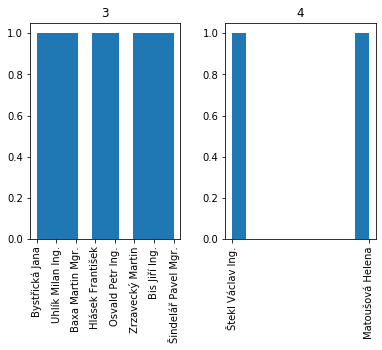

In [12]:
a = cand2['jmeno'].hist(by=cand2['mandaty'])

Čemuž odpovídá také následující graf reprezentující všechny hlasy pro jednotlivé kandidáty a celkový počet hlasů, které za ně jejich strany získaly

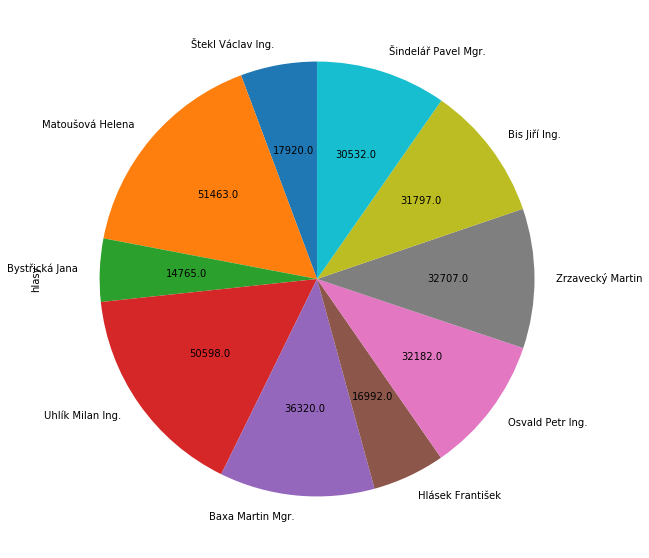

In [13]:
fun = lambda x: round((x/100)*cand2['hlasy'].sum())
a=cand2.plot(kind='pie', y='hlasy',labeldistance=1.1, legend=False, figsize=(10, 10), autopct=fun,startangle=90)

Nejaktivnější kandidáti patří vesměs do 3 politických stran, kde všechny z nich patří k nejvolenějším ve městě Plzeň. Z následujícího grafu vidíme, kolik hlasů kandidáti svým stranám v jednotlivých letech přinesli.

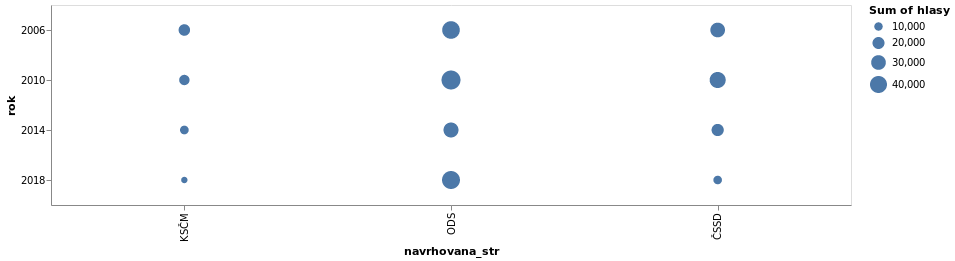

In [14]:
results_top = candidates[candidates['jmeno'].isin(cand2['jmeno'])]

alt.Chart(results_top, height=200, width=800).mark_circle().encode(
    alt.X('navrhovana_str:N', bin=False),
    alt.Y('rok:O', bin=False),
    size='sum(hlasy)'
)

#### Graf zisku hlasů nejaktivnějších kandidátů v pro jednotlivé roky

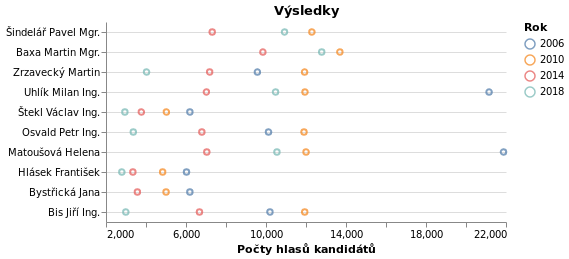

In [15]:
chart = alt.Chart(results_top, title="Výsledky").mark_point().encode(
    alt.X(
        'hlasy:Q',
        title="Počty hlasů kandidátů",
        scale=alt.Scale(zero=False),
        axis=alt.Axis(grid=False)
    ),
    alt.Y(
        'jmeno:N',
        title="",
        sort=alt.EncodingSortField(field='yield', op='max', order='descending'),
        scale=alt.Scale(rangeStep=20),
        axis=alt.Axis(grid=True)
    ),
    color=alt.Color('rok:N', legend=alt.Legend(title="Rok")),
  
).configure_view(stroke="transparent")

party_drop = alt.binding_select(options=list(set(list(cand2['strana']))))
party_select = alt.selection_single(fields=['navrhovana_str'], bind=party_drop, name="Strana")

filter_party = chart.add_selection(
    party_select
).transform_filter(
    party_select
)

(filter_party)